# SageMaker/DeepAR demo on a restaurant dataset

DeepAR stands for Deep Autoregression. Autoregression is used to model time-series with autocorrelation, i.e. the succesive values in time series are not independent of each other. In DeepAR, we exploit the power of recurrent neural network to model the complexity of time-sequences. The model learns to forecast parameters of a chosen distribution, which is most likely to generate the target values. One can also add external regressors to the model. The built-in algorithm identifies different levels of seasonality present in the time series data on its own.         

For more information see the DeepAR [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) or [paper](https://arxiv.org/abs/1704.04110).

### Index 
Here, we will consider a real use case and show how to use DeepAR on SageMaker for forecasting sales of 4 products accross 25 stores for a recursive period of 2 weeks.

In particular, we will see how to:

* Prepare the dataset.
    * [Import ProductStore dataset](#Import-ProductStore-dataset)
    * [Adding extraneous variables](#Adding-extraneous-variables)
    * [Data Preprocessing](#Data-Preprocessing)
    * [Data Visualization](#Data-Visualization)

* Use the SageMaker Python SDK to train a DeepAR model and deploy it.
    * [Preparing for Sagemaker Training and Inference](#Preparing-for-Sagemaker-Training-and-Inference)
    * [Train and Test splits](#Train-and-Test-splits)
    * [DeepAR Container](#DeepAR-Container)
    * [Sagemkaer Training](#Sagemaker-Training)
    * [Create endpoint and predictor](#Create-endpoint-and-predictor)
    
* Make requests to the deployed model to obtain forecasts interactively
    * [Make predictions and plot results](#Make-predictions-and-plot-results)

* Clean up
    * [Delete endpoints](#Delete-endpoints)

Note: We will be using **us-east-1** region for all our exercises.

### Installing & Importing required packages

In [1]:
!pip install holidays  # to install the holidays package

import warnings
import deeparpredictor
import holidays
from ipywidgets import IntSlider, FloatSlider, Checkbox
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sagemaker
import boto3
import time
from random import randint
import datetime
import random
import json
from dateutil.parser import parse

% matplotlib inline

warnings.filterwarnings('ignore')

    100% |████████████████████████████████| 112kB 13.5MB/s ta 0:00:01
    100% |████████████████████████████████| 737kB 25.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for holidays ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/7a/47/8c/4413b01a0f220ad58dbb162b4e8f5f3638b150407b6ea042fa
  Running setup.py bdist_wheel for pymeeus ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/d6/a7/fd/a3cc8df9eb57b13a7e8935c406627e3d7f41cd511010b02e9c
Successfully built holidays pymeeus
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### Setting random seeds

In [2]:
np.random.seed(42)
random.seed(42)

### Import ProductStore dataset 
The data is made available to you in the folder.

The data is originally recorded at day level intervals for combination of stores and products. Since the data is already at day level interval, we can directly load and process the dataset.

In [3]:
# reading the raw dataset
data = pd.read_csv('data_raw.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.sort_values(by=['Store_ID', 'Product_ID', 'Date'])
data = data.reset_index()
data = data.drop(['index'], axis=1)
data['Turnover'] = data['SalesCount'] * data['Price']
print(data.head())

        Date  Store_ID  Product_ID      Product_Name  Price  AnnualSalesWeek  \
0 2013-05-01         1        1001  margherita pizza      8                0   
1 2013-05-02         1        1001  margherita pizza      8                0   
2 2013-05-03         1        1001  margherita pizza      8                0   
3 2013-05-04         1        1001  margherita pizza      8                0   
4 2013-05-05         1        1001  margherita pizza      8                0   

   SalesCount  Turnover  
0           4        32  
1           3        24  
2           6        48  
3           6        48  
4           2        16  


### Adding extraneous variables
As we will observe later in this notebook, there are multiple seasonality factors in the data like weekly seasonality, yearly seasonality etc. But there are certain special days that appear on irregular intervals whose impact is visible on sales. We will add them to the model as dynamic features. The following snippet adds columns for these dynamic features into our data.

In [4]:
# Creating binary variable for BlackFriday
us_holidays = holidays.UnitedStates()

data['Holiday'] = [us_holidays.get(item) for item in data['Date']]
data['Thanksgiving'] = data['Holiday'] == 'Thanksgiving'
data['BlackFriday'] = [
    1 if item else 0 for item in data['Thanksgiving'].shift(1).fillna(False)]

data = data.drop(['Holiday', 'Thanksgiving'], axis=1)
ext_features = ['BlackFriday', 'AnnualSalesWeek']
print(data.head())

        Date  Store_ID  Product_ID      Product_Name  Price  AnnualSalesWeek  \
0 2013-05-01         1        1001  margherita pizza      8                0   
1 2013-05-02         1        1001  margherita pizza      8                0   
2 2013-05-03         1        1001  margherita pizza      8                0   
3 2013-05-04         1        1001  margherita pizza      8                0   
4 2013-05-05         1        1001  margherita pizza      8                0   

   SalesCount  Turnover  BlackFriday  
0           4        32            0  
1           3        24            0  
2           6        48            0  
3           6        48            0  
4           2        16            0  


### Data Preprocessing
We convert the data to a collection of Pandas time series. It makes common time series operations such as indexing by time periods or resampling much easier. Once the data is processed, each store product combination will have a seperate timeseries.

In [5]:
# Indexing all the unique stores and products present in the data
prod_dict = dict(enumerate(data.Product_ID.unique()))
store_dict = dict(enumerate(data.Store_ID.unique()))

In [6]:
cat = []  # will store the unique combination of ProductID and StoreID
timeseries = []  # will store the series
dynamic_feat = []  # will store the continuous independent variables of the data

ts_dict = {}  # Stores index of timeseries in the list corresponding to indices of store and product

for i in store_dict:
    for j in prod_dict:
        df = data[(data['Store_ID'] == store_dict[i]) &
                  (data['Product_ID'] == prod_dict[j])]
        df = df.set_index('Date')

        # begin triming from 1st nonzero value
        series = np.trim_zeros(df.loc[:, 'SalesCount'], trim='f')
        timeseries.append(series)
        dynamic_feat.append(df.loc[series.index, ext_features])
        cat.append([i, j])
        ts_dict[i, j] = len(timeseries) - 1

### Data Visualization 
Plotting the resulting time series. We observe that there is **weekly seasonality** in the timeseries.

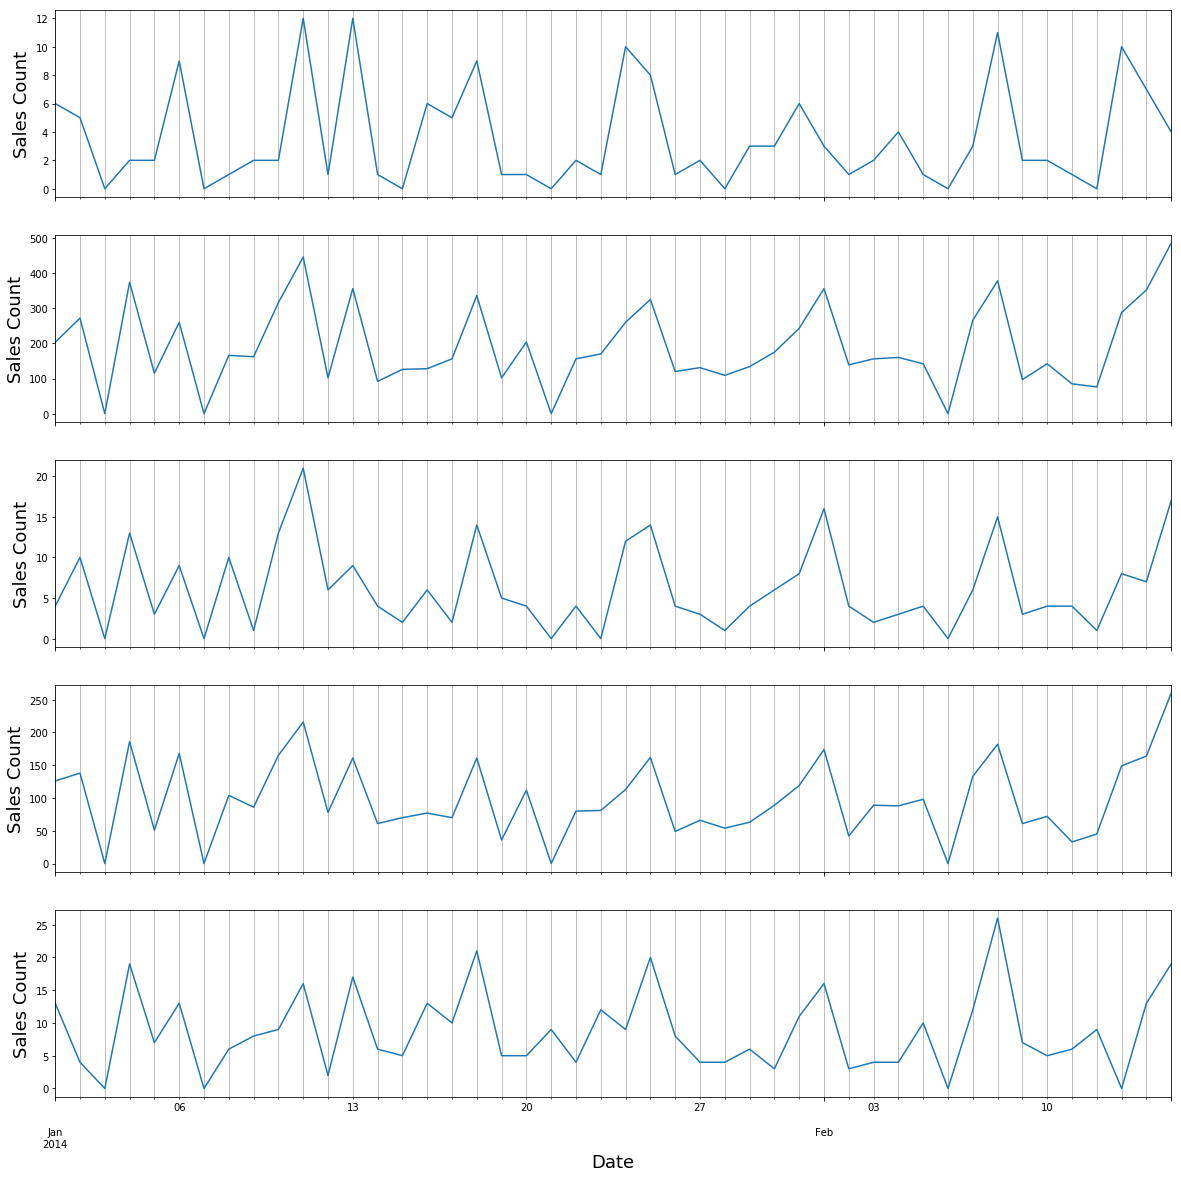

In [7]:
fig, axs = plt.subplots(5, 1, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 5):
    timeseries[i].loc["2014-01-01":"2014-02-15"].plot(ax=axx[i])
    axx[i].set_xlabel("Date", fontsize=18)
    axx[i].set_ylabel("Sales Count", fontsize=18)
    axx[i].grid(which='minor', axis='x')

Also observe that there is **yearly seasonality** in the data. There are relative spikes in sales on Blackfriday and during AnnualSalesWeek.

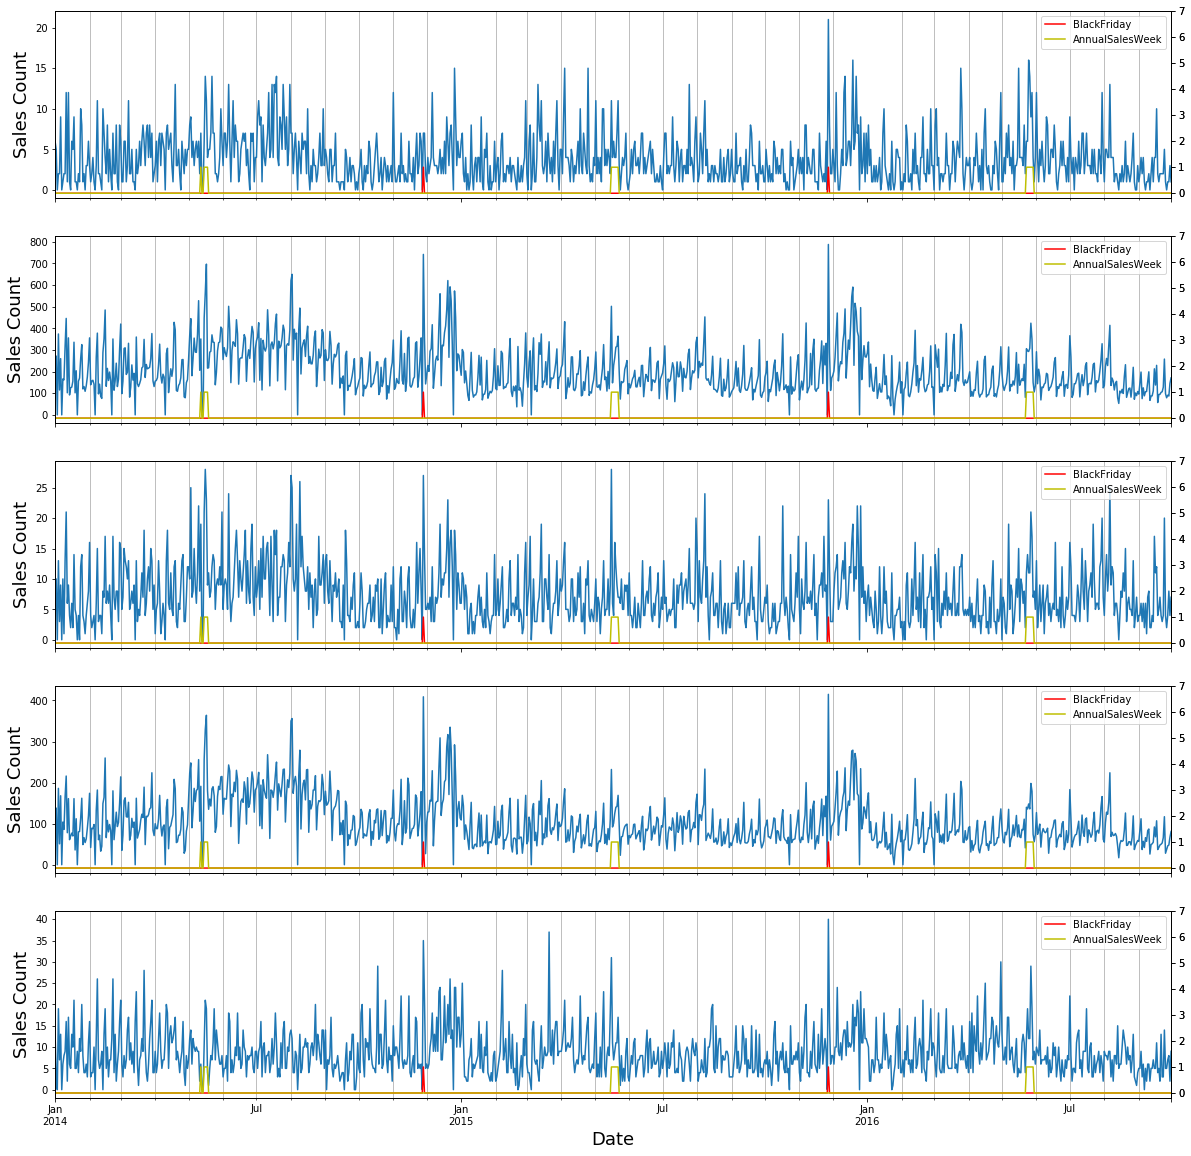

In [8]:
fig, axs = plt.subplots(5, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 5):
    timeseries[i].loc["2014-01-01":"2016-09-30"].plot(ax=axx[i])
    axx[i].set_xlabel("Date", fontsize=18)
    axx[i].set_ylabel("Sales Count", fontsize=18)
    axx[i].grid(which='minor', axis='x')

    ax2 = axx[i].twinx()
    dynamic_feat[i].loc["2014-01-01":"2016-09-30",
    'BlackFriday'].plot(ax=ax2, color='r', legend='BlackFriday')
    ax2.set_ylim(-0.2, 7)

    ax3 = axx[i].twinx()
    dynamic_feat[i].loc["2014-01-01":"2016-09-30",
    'AnnualSalesWeek'].plot(ax=ax2,
                            color='y',
                            legend='AnnualSalesWeek')
    ax3.set_ylim(-0.2, 7)

### Preparing for Sagemaker Training and Inference
Before starting, we create a S3 bucket and set the IAM role to give access for training and hosting the data.
After bucket creation, it can be seen on the console [here.](https://s3.console.aws.amazon.com/s3/home?region=us-east-1#)

In [9]:
# creating a new bucket
client = boto3.client('s3')
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')
bucketName = 'deepar-sagemaker-demo-' + str(randint(1, 999999)) + '-' + st

res = client.create_bucket(Bucket=bucketName)
s3_bucket = bucketName
# prefix used for all data stored within the bucket
s3_prefix = 'deepar-demand-forecasting'

print("Bucket Created with name:", bucketName)

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

region = sagemaker_session.boto_region_name

Bucket Created with name: deepar-sagemaker-demo-670488-2020-02-14-13-52-57


In [10]:
%%time

s3 = boto3.resource('s3')


def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(
                'File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(
                    s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)


s3_data_path = "s3://{}/{}-data/data".format(
    s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}-data/output".format(
    s3_bucket, s3_prefix)


CPU times: user 10.6 ms, sys: 8.01 ms, total: 18.6 ms
Wall time: 26.6 ms


#### Specifying some high level features

Next, we specify some high level features like the frequency, prediction length(number of days) and context length for timeseries.

In [11]:
# we use Daily frequency for the time series
freq = 'D'

# we predict for the next 14 days
prediction_length = 14

### Train and Test splits

Often times one is interested in evaluating the model or tuning its hyperparameters by looking at error metrics on a hold-out test set. Here we split the available data into train and test sets for evaluating the trained model. For standard machine learning tasks such as classification and regression, one typically obtains this split by randomly separating examples into train and test sets. However, **in forecasting it is important to do this train/test split based on time.**

In [12]:
start_dataset = min(data['Date'])  # setting start data for training
end_training = datetime.datetime.strptime(
    '2016-8-10',
    '%Y-%m-%d') - datetime.timedelta(91)  # setting end data for training

The DeepAR JSON input format represents each time series as a JSON object. In the simplest case each time series just consists of a start time stamp (``start``) and a list of values (``target``). For more complex cases, DeepAR also supports the fields ``dynamic_feat`` for time-series features and ``cat`` for categorical features. We shall insert Blackfriday and AnnualSalesWeek as dynamic features, store and product indices as categorical features. 

The model creates embeddings for categorical features. We shall exclude some of the store-product combinations from the training data. The idea is to evaluate if the model can learn to forecast for these combinations by interaction of embeddings learnt through other occurances of the store or the product.

In [13]:
exclude = [[22, 3], [4, 2]]

In [14]:
%%time

def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]


train_data = [{"start": str(start_dataset),
               "target": encode_target(timeseries[ts_dict[i, j]][start_dataset:end_training]),
               "cat": [i, j],
               "dynamic_feat": [dynamic_feat[ts_dict[i, j]].loc[start_dataset:end_training, feat].tolist() for feat in
 ext_features]} for i, j in cat if cat not in exclude]

print(len(train_data))


100
CPU times: user 256 ms, sys: 0 ns, total: 256 ms
Wall time: 257 ms


As test data, we have considered time series extending beyond the training range for a period of 8 weeks. These will be used for computing test scores, by using the trained model to forecast the succeeding 8 weeks, and comparing predictions with actual values.
To evaluate our model performance on more than one week, we generate test data that extends for 8 number of weeks beyond the training range. This way we perform *rolling evaluation* of our model.

In [15]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": encode_target(
            timeseries[ts_dict[i, j]][start_dataset:end_training + datetime.timedelta(k * prediction_length)]),
        "cat": [i, j],
        "dynamic_feat": [
            dynamic_feat[ts_dict[i, j]].loc[start_dataset:end_training + datetime.timedelta(k * prediction_length),
            feat].tolist() for feat in ext_features]
    }
    for k in range(1, num_test_windows + 1)
    for i, j in cat
]


Let's now write the dictionary to the `jsonlines` file format that DeepAR understands (it also supports gzipped jsonlines and parquet).

In [16]:
%%time


def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))


# storing files locally
write_dicts_to_file("train_data.json", train_data)
write_dicts_to_file("test_data.json", test_data)

CPU times: user 166 ms, sys: 20.2 ms, total: 186 ms
Wall time: 186 ms


#### Uploading train and test data to S3

Now that we have the data files locally, let us copy them to S3 where Sagemaker can access them. Using the boto3 library we upload the data to the bucket.
You can see the files in your bucket on the console [here.](https://s3.console.aws.amazon.com/s3/home?region=us-east-1#)

In [17]:
# uplaoding file to S3
print('Uploading to S3 this may take a few minutes depending on your connection.')
copy_to_s3("train_data.json", s3_data_path + "/train/train_data.json", override=True)
copy_to_s3("test_data.json", s3_data_path + "/test/test_data.json", override=True)

Uploading to S3 this may take a few minutes depending on your connection.
Uploading file to s3://deepar-sagemaker-demo-670488-2020-02-14-13-52-57/deepar-demand-forecasting-data/data/train/train_data.json
Uploading file to s3://deepar-sagemaker-demo-670488-2020-02-14-13-52-57/deepar-demand-forecasting-data/data/test/test_data.json


Saving the S3-location of training and testing data.

In [20]:
location_dict = {'train_data_location': "{}/train/".format(s3_data_path),
                 'test_data_location': "{}/test/".format(s3_data_path), 's3_output_path': "s3://{}/{}-data/output"
                 .format(s3_bucket, s3_prefix)}

with open("location.json", 'wb') as fp:
    fp.write(json.dumps(location_dict).encode("utf-8"))

### DeepAR Container
We pull the container image to be used for the region that we are running in. This contains the DeepAR model developed by Amazon.

The advantage of using a built-in algorithm is that you don't have to worry about the environment setup, the internal working of the algorithm, etc. A user with limited understanding of machine learning can also implement these techniques on their own data. The inference can be obtained through very simple api call.

In [21]:
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

### Sagemaker Training
We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last `prediction_length` points of each time-series in the test set and comparing this to the actual value of the time-series. 

**Note:** The next cell may take a few minutes to complete, depending on data size, model complexity, training options.
You can also see the progress of the training job in the console [here.](https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/jobs)

In [22]:
hyperparameters = {
    "time_freq": freq,
    "context_length": '14',
    "prediction_length": str(prediction_length),
    "epochs": "500",
    "likelihood": "negative-binomial",
    "early_stopping_patience": "40",
}


estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-timeseries',
    output_path=s3_output_path,
    hyperparameters=hyperparameters,
    tags=[{"Key": "project", "Value": "Sagemaker-Demo"}],
    
)


estimator.fit(
    inputs={
        "train": location_dict['train_data_location'],
        "test": location_dict['test_data_location']
    },
    wait=True
)

2020-02-14 13:54:38 Starting - Starting the training job...
2020-02-14 13:54:39 Starting - Launching requested ML instances......
2020-02-14 13:55:44 Starting - Preparing the instances for training...
2020-02-14 13:56:33 Downloading - Downloading input data...
2020-02-14 13:57:02 Training - Downloading the training image...
2020-02-14 13:57:21 Training - Training image download completed. Training in progress.Arguments: train
[02/14/2020 13:57:24 INFO 140158294705984] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'au

### Create endpoint and predictor

Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

**Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.**

To query the endpoint and perform predictions, we can define the following utility class, which allows us to make requests using `pandas.Series` objects rather than raw JSON strings.

Now we can deploy the model and create and endpoint that can be queried using our custom DeepARPredictor utility class.
You can also see the progress of the endpoint creation in the console [here.](https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/endpoints)

In [23]:
%%time
# creating the endpoint
predictor = estimator.deploy(
    initial_instance_count=1,  
    instance_type='ml.m4.xlarge',  
    predictor_cls=deeparpredictor.DeepARPredictor)

-------------------!CPU times: user 309 ms, sys: 28.8 ms, total: 337 ms
Wall time: 9min 32s


### Make predictions and plot results

Now we can use the `predictor` object to generate predictions.

We can interact with sliders to look at the forecast of any store product combination. `forecast_day` will specify the number of days after end_training after which to begin forecasting. With `confidence`, we can set the range of prediction interval for the negative-binomial distribution of the target variable. For each request, the predictions are obtained by calling our served model on the fly.
 
Click on `Run Interact` to generate the predictions from the endpoint and see the plot.

The visualization shows line chart of actual vs predicted time-series. The blue line is 50-percentile value of the predicted distribution, the shaded region is prediction interval of the predicted distribution of target variable. 

In [24]:
style = {'description_width': 'initial'}

store_id = 1
product_id = 1


@interact_manual(
    store_id=IntSlider(min=0, max=len(store_dict) - 1, value=1, style=style),
    product_id=IntSlider(min=0, max=len(prod_dict) - 1, value=1, style=style),
    forecast_day=IntSlider(min=0, max=77, value=21, style=style),
    confidence=IntSlider(min=60, max=95, value=90, step=5, style=style),
    continuous_update=False
)
def plot_interact(store_id, product_id, forecast_day, confidence):
    forecast_date = end_training + datetime.timedelta(days=forecast_day)
    target = timeseries[ts_dict[store_id, product_id]][
             start_dataset:forecast_date + datetime.timedelta(prediction_length)]
    dynamic_features = [dynamic_feat[ts_dict[store_id, product_id]].loc[
                        start_dataset:forecast_date + datetime.timedelta(prediction_length), feat].tolist() for feat in
                        ext_features]

    deeparpredictor.plot(predictor,
                         target_ts=target,
                         cat=[store_id, product_id],
                         dynamic_feat=dynamic_features,
                         forecast_date=end_training,
                         plot_history=4,
                         confidence=confidence,
                         prediction_length=prediction_length
                         )

interactive(children=(IntSlider(value=1, description='store_id', max=24, style=SliderStyle(description_width='…

### Delete endpoints
This is the clean up of the endpoint. Uncomment(remove #) and execute the below command to delete the endpoint.

In [ ]:
#predictor.delete_endpoint() 